# Auswertung Schleppleistungsmessung

Folgendes Notebook wird verwendet um für verschiedene Traktortypen die Messdaten auszuwerten.

In [430]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [431]:
# SELECT TRACTOR TO EVALUATE
# TRACTOR = 'Fiat_56'
TRACTOR = 'NewhollandT6.180'

In [432]:
files = {
    'Fiat_56': 'Fiat_56_Schlepp_warm_motorenbremse_2023-03-31_10-30-37.xls',
    'NewhollandT6.180': 'NewhollandT6.180Schlepp_motorbremse_2023-04-06_14-47-06.xls',
    'NewhollandT6.175': 'NewhollandT6.175Schlepp_Motorenbremse_2023-04-06_15-14-46.xls',
    'NewhollandT5.140': 'NewhollandT5.140Schlepp_motorbremse_2023-04-06_14-12-14.xls'
}

df = pd.read_excel(files[TRACTOR])

*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


In [433]:
df

,Zeit,Ch1,RPM-Value
0,NaN,Channel 1,RPM-Value
1,[sec],[V],[1/min]
2,0,-0.167509,1
3,0.151017,-0.168187,1
4,0.302034,-0.167848,1
...,...,...,...
3673,554.384237,-0.079685,4
3674,554.535254,-0.079685,4
3675,554.686271,-0.080703,4
3676,554.837289,-0.080024,4


### Angleichung und Berechnung passender Werte
Ausgeglichen werden:
- Sensorungenauigkeit
- Konvertierung gemessener Volt am Sensor zu Drehzahl (RPM)
- Einrechnung der Ineffizienz zwischen Motorwelle und Zapfenwelle
- Konvertierung von positiven zu negativen Werten für die Schleppleistung
- Umrechnung Übersetzungsverhältnis von Zapfwellendrehzahl (gemessen) zu Motordrehzahl
- Konvertierung des Datentyps zu Dezimal (float) und Ganzzahlen (integer)

In [434]:
# remove unused excel header rows
df = df.iloc[2:]

# sensor deviation factor, as sensor did not measure very correctly.
# using the first 20 values and match them to zero, as first readings should
# have been zero if sensor measured correctly.
SENSOR_DEVIATION_FACTOR = df['Ch1'].iloc[:20].mean()
df['Ch1'] = df['Ch1'] - SENSOR_DEVIATION_FACTOR

# convert Ch1 [Volt] to Newtonmeter
VOLT_TO_NEWTON_FACTOR = 299.2606857
df['Ch1'] = df['Ch1'] * VOLT_TO_NEWTON_FACTOR

# subtract inefficiency from translation from motor to measuring device
INEFFICIENCIES = {
    'Fiat_56': 0.28,
    'NewhollandT6.180': 0.51,
    'NewhollandT6.175': 0.51
}
df['Ch1'] = df['Ch1'] * (1 - INEFFICIENCIES[TRACTOR])

# Convert Newtonmeter to negative, as its breaking force
df['Ch1'] = df['Ch1'] * (-1)

# RPM Conversion measured at measuring device converted to Motor
RPM_RATIOS = {
    'Fiat_56': 3.57,
    'NewhollandT6.180': 1.93,
    'NewhollandT6.175': 1.93
}
df['RPM-Value-Motor'] = df['RPM-Value'] * RPM_RATIOS[TRACTOR]

# fix object to float types
df['Zeit'] = df['Zeit'].astype(float)
df['Ch1'] = df['Ch1'].astype(float)
df['RPM-Value'] = df['RPM-Value'].astype(int)
df['RPM-Value-Motor'] = df['RPM-Value-Motor'].astype(float)

# TODO: cut off rows which are way off

df

/tmp/ipykernel_1741/3232008095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ch1'] = df['Ch1'] - SENSOR_DEVIATION_FACTOR
/tmp/ipykernel_1741/3232008095.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ch1'] = df['Ch1'] * VOLT_TO_NEWTON_FACTOR
/tmp/ipykernel_1741/3232008095.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,Zeit,Ch1,RPM-Value,RPM-Value-Motor
2,0.000000,-9.944575e-02,1,1.93
3,0.151017,4.070015e-14,1,1.93
4,0.302034,-4.972288e-02,1,1.93
5,0.453052,-1.491686e-01,1,1.93
6,0.604069,-9.944575e-02,1,1.93
...,...,...,...,...
3673,554.384237,-1.297767e+01,4,7.72
3674,554.535254,-1.297767e+01,4,7.72
3675,554.686271,-1.282850e+01,4,7.72
3676,554.837289,-1.292795e+01,4,7.72


## Separation Schleppbremse und Normal

In [435]:
# save start and end for good plots, to remove long prefix data
ranges = {
    'Fiat_56': (0, 6200),
    'NewhollandT6.180': (50, 450),
    'NewhollandT6.175': (40, 430)
}
# define two points for each tractor to find a fitting separation line for the data
points = {
    'Fiat_56': ((0, -100), (800, -220)),
    'NewhollandT6.180': ((50, -180), (400, -280)),
    'NewhollandT6.175': ((50, -150), (400, -240))
}
start, end = ranges[TRACTOR]
df = df[(df['Zeit'] > start) & (df['Zeit'] < end)]
df

,Zeit,Ch1,RPM-Value,RPM-Value-Motor
334,50.137719,-135.544562,535,1032.55
335,50.288736,-136.290405,535,1032.55
336,50.439754,-137.732369,535,1032.55
337,50.590771,-137.533477,535,1032.55
338,50.741788,-134.500382,535,1032.55
...,...,...,...,...
2977,449.276248,-373.269636,1125,2171.25
2978,449.427265,-371.131552,1125,2171.25
2979,449.578282,-379.286104,1125,2171.25
2980,449.729299,-378.540261,1125,2171.25


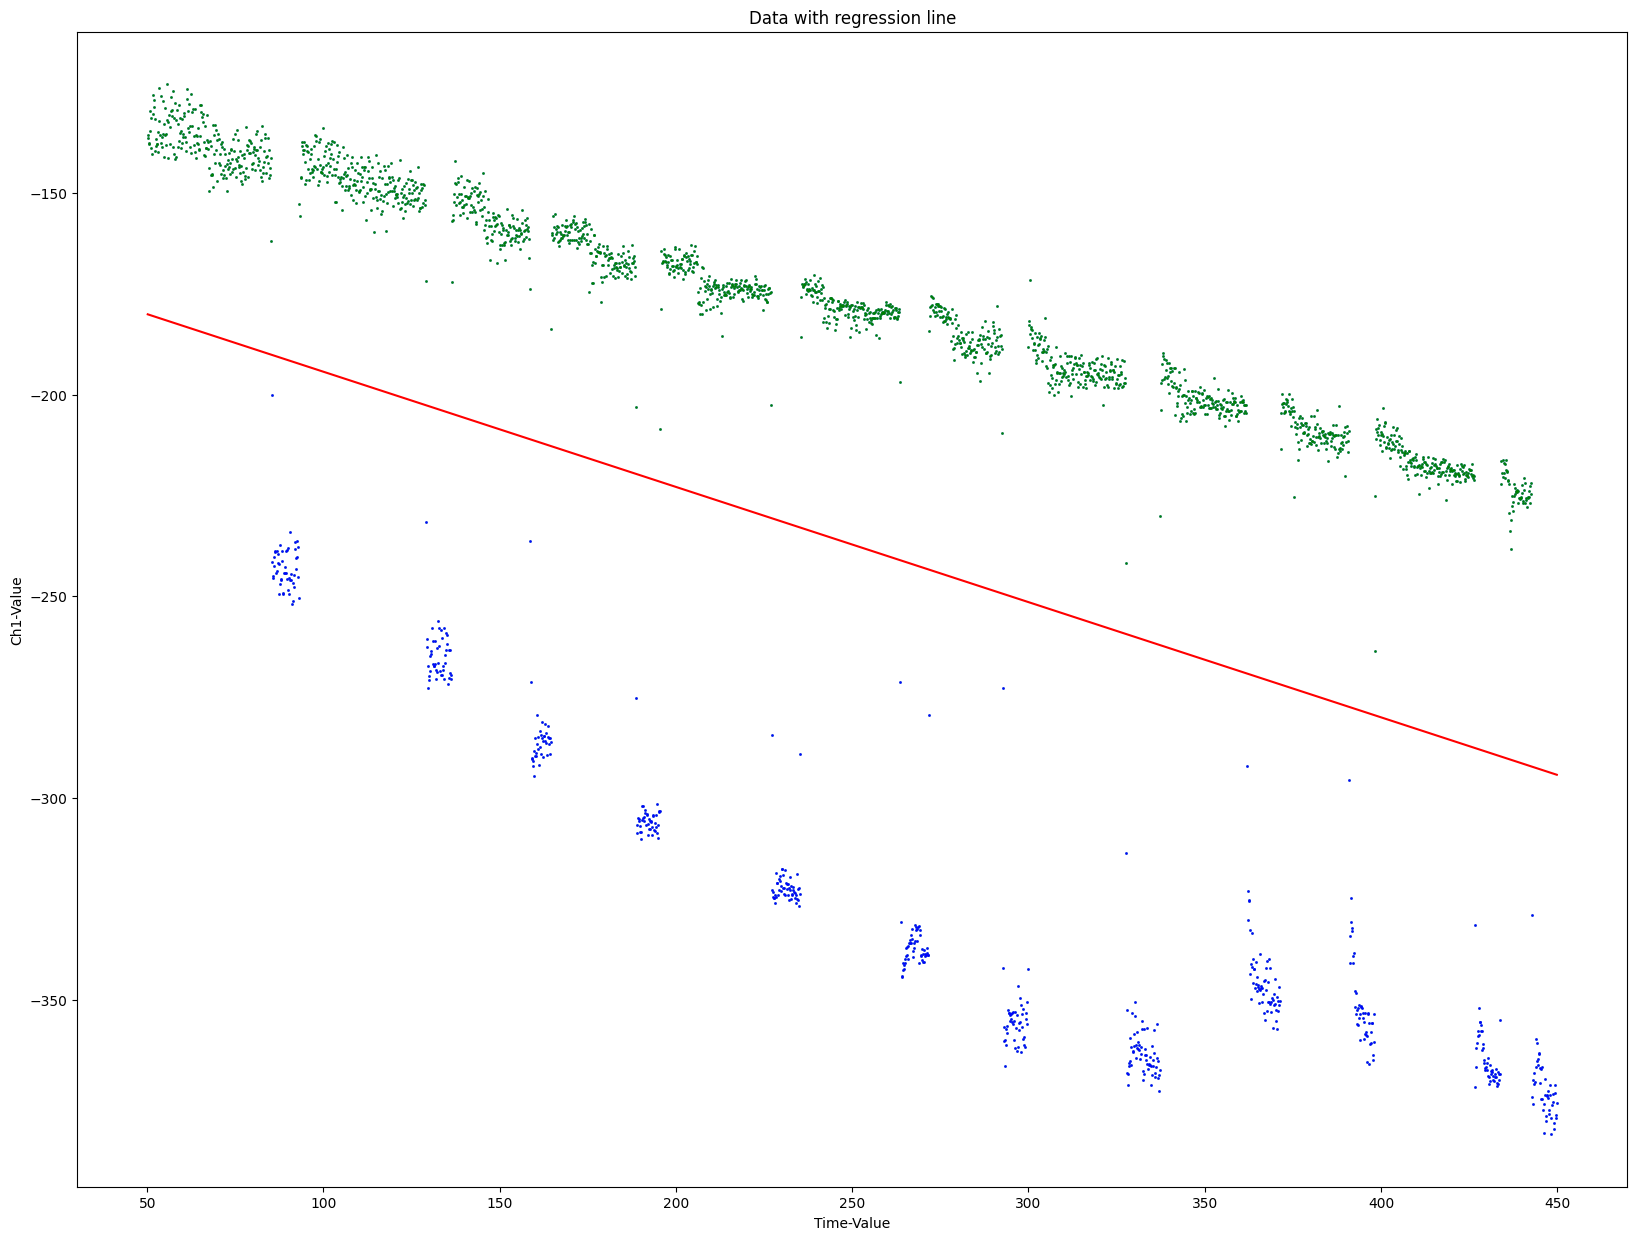

In [436]:
plt.figure(figsize=(20, 15))

point1, point2 = points[TRACTOR]

slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
intercept = point1[1] - slope * point1[0]

#separate datapoints above and below regression line
above_line = df[df['Ch1'] >= slope * df['Zeit'] + intercept]
below_line = df[df['Ch1'] < slope * df['Zeit'] + intercept]

#visualize data and regression line
plt.scatter(df['Zeit'], df['Ch1'], alpha=0.8, s=1) # scatter plot of datapoints
plt.scatter(above_line['Zeit'], above_line['Ch1'], color='green', alpha=0.8, s=0.8) # scatter plot of points above regression line
plt.scatter(below_line['Zeit'], below_line['Ch1'], color='blue', alpha=0.8, s=0.8) # scatter plot of points below regression line
plt.plot(df['Zeit'], slope * df['Zeit'] + intercept, color='red') # line plot of regression line
plt.title("Data with regression line")
plt.xlabel("Time-Value")
plt.ylabel("Ch1-Value")
plt.show()

# Plot Nm vs RPM Motor

In [437]:
# computes confidence interval for 95%
def regression_ci(x, y, degree, ci=95):
    """
    Compute the confidence interval for a polynomial regression
    of degree `degree` fit to the data `x` and `y` at the given
    `ci` level of confidence.
    
    Returns a tuple (coeffs, lower, upper) where coeffs are the
    polynomial coefficients, lower and upper are vectors giving
    the lower and upper bounds of the confidence interval at
    each `x` value.
    """
    coeffs = np.polyfit(x, y, degree)
    line_function = np.poly1d(coeffs)
    
    # compute predicted values and standard error
    y_hat = line_function(x)
    resid = y - y_hat
    df = x.size - (degree + 1)
    mse = np.sum(resid ** 2) / df
    se = np.sqrt(mse * (1 + 1/x.size + (x - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)))
    
    # compute confidence bounds
    alpha = 1 - ci / 100
    tval = np.abs(stats.t.ppf(alpha/2, df))
    lower = line_function(x) - tval * se
    upper = line_function(x) + tval * se
    
    return coeffs, lower, upper

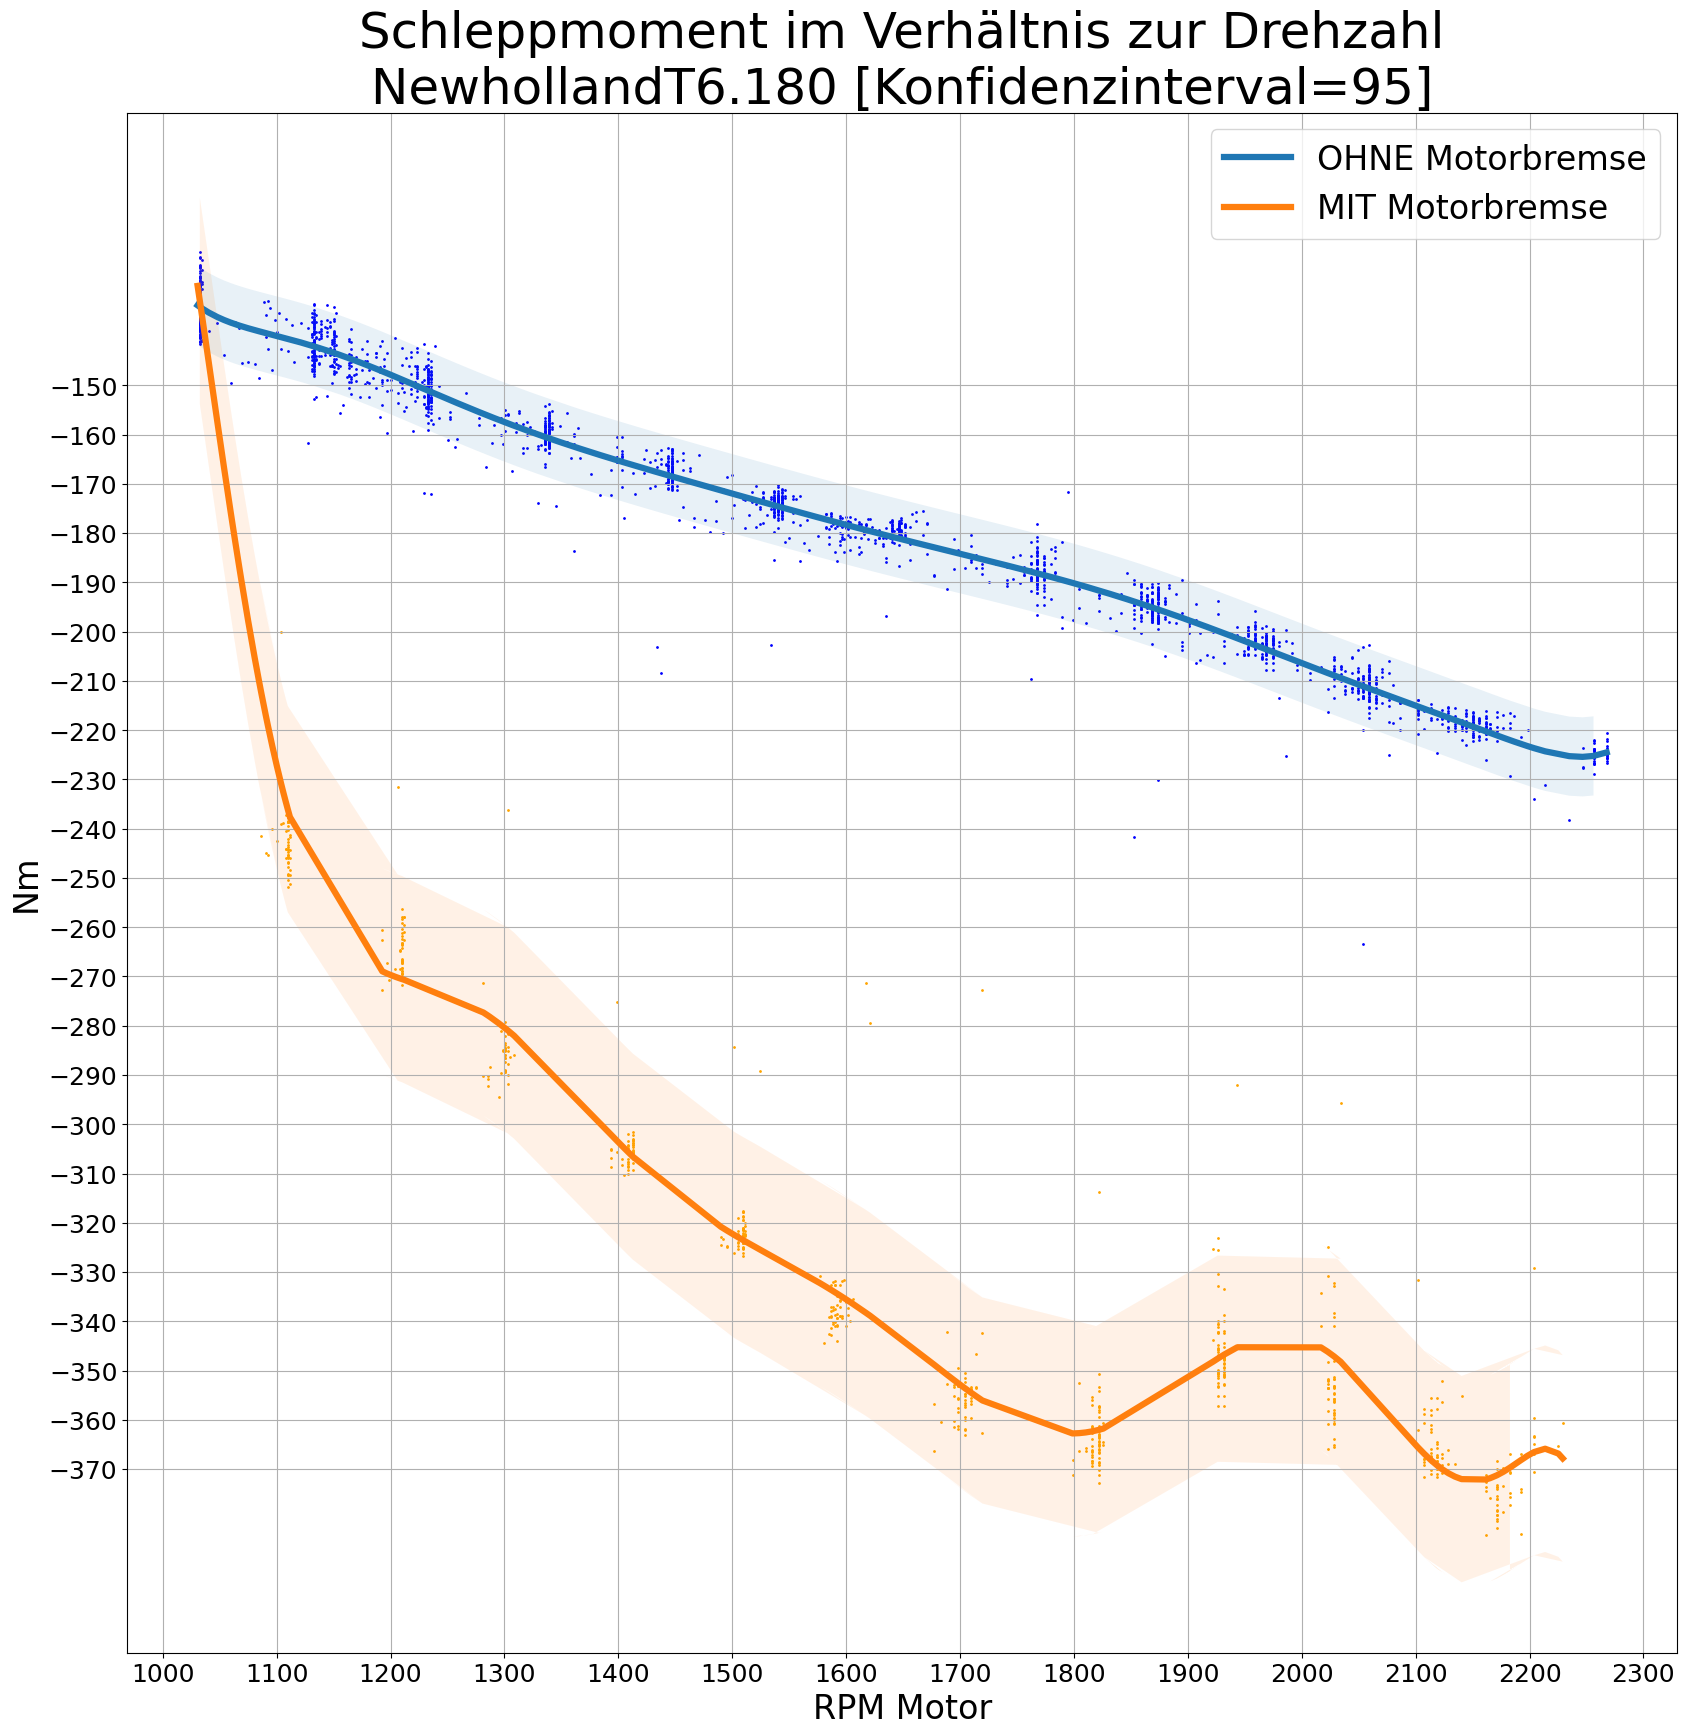

In [438]:
plt.figure(figsize=(20, 20))

# show all points
plt.scatter(data=above_line, x='RPM-Value-Motor', y='Ch1', color='blue', alpha=1, s=1, label='')
plt.scatter(data=below_line, x='RPM-Value-Motor', y='Ch1', color='orange', alpha=1, s=1, label='')

# automatically add the first few points from the OHNE dataset to the MIT,
# as MIT has the same "schleppmomentum" when no "motorbremse" is available at low RPM
min_rpm = below_line['RPM-Value-Motor'].min()
rows_to_prepend = above_line[above_line['RPM-Value-Motor'] < min_rpm]
below_line = pd.concat([rows_to_prepend, below_line], ignore_index=True)

# # fit and plot regression lines above_line and below_line
for name, data in [('OHNE Motorbremse', above_line), ('MIT Motorbremse', below_line)]:
    # fit linear regression
    coefficients = np.polyfit(data['RPM-Value-Motor'], data['Ch1'], 10)
    line_function = np.poly1d(coefficients)
    # plot line with label
    sns.lineplot(x=data['RPM-Value-Motor'], y=line_function(data['RPM-Value-Motor']), label=f'{name}', linewidth=4.5)
    coeffs, lower, upper = regression_ci(data['RPM-Value-Motor'], data['Ch1'], 10, ci=95)
    line_function = np.poly1d(coeffs)
    # plot confidence interval
    plt.fill_between(data['RPM-Value-Motor'], lower, upper, alpha=0.1)

# # set labels and title
plt.xlabel('RPM Motor', fontsize=24)
plt.ylabel('Nm', fontsize=24)
plt.title(f"Schleppmoment im Verhältnis zur Drehzahl\n{TRACTOR} [Konfidenzinterval=95]", fontsize=36)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
# Set tick positions on the y-axis on divisible by 10
ystart = np.ceil(df['Ch1'].min()/10) * 10
yend = np.ceil(df['Ch1'].max()/10) * 10
plt.yticks(np.arange(ystart + 10, yend - 20, 10))
# # Set tick positions on the x-axis
xstart = np.ceil(df['RPM-Value-Motor'].min()/100) * 100
xend = np.ceil(df['RPM-Value-Motor'].max()/100) * 100
plt.xticks(np.arange(xstart - 100, xend + 100, 100))
plt.grid(which='both')
plt.legend(loc=1, fontsize=24)

plt.ion()
plt.savefig(f"graphs/{TRACTOR}.png")